In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import seaborn as sns
import folium
import folium.plugins as plugins
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# Data Preparation

## Trip Duration Clean-up
Deal with **outliers** associated with the `trip_duration` variable  
Exclude data that lies outside 2 standard deviations from the mean. 

In [4]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

## Check latitude/longitude bounds
Latitude: -85 to +85, Longitude: -180 to +180

In [5]:
print('Latitude bounds: {} to {}'.format(
    max(train.pickup_latitude.min(), train.dropoff_latitude.min()),
    max(train.pickup_latitude.max(), train.dropoff_latitude.max())
))

Latitude bounds: 34.359695434570305 to 51.88108444213867


In [6]:
print('Longitude bounds: {} to {}'.format(
    max(train.pickup_longitude.min(), train.dropoff_longitude.min()),
    max(train.pickup_longitude.max(), train.dropoff_longitude.max())
))

Longitude bounds: -121.9333038330078 to -61.33552932739258


**Visualize some outliers locations on map**

In [7]:
# will take some time to run this:
import folium
map_1 = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap', zoom_start=12)
for each in train[100000:1000000].iterrows():
     if (each[1]['pickup_latitude']<35 or each[1]['pickup_latitude']>50) or (each[1]['pickup_longitude']<-100 or each[1]['pickup_longitude']>-65): 
        folium.CircleMarker([each[1]['pickup_latitude'],each[1]['pickup_longitude']],
                        radius=3,
                        color='red',
                        popup=str(each[1]['pickup_latitude'])+','+str(each[1]['pickup_longitude']),
                        fill_color='#FD8A6C'
                        ).add_to(map_1)
map_1

Few locations are getting centred in sea and it is impossible to take a ride on the sea.  
So we have to clean-up on latitude and longitude

## Latitude and Longitude Clean-up

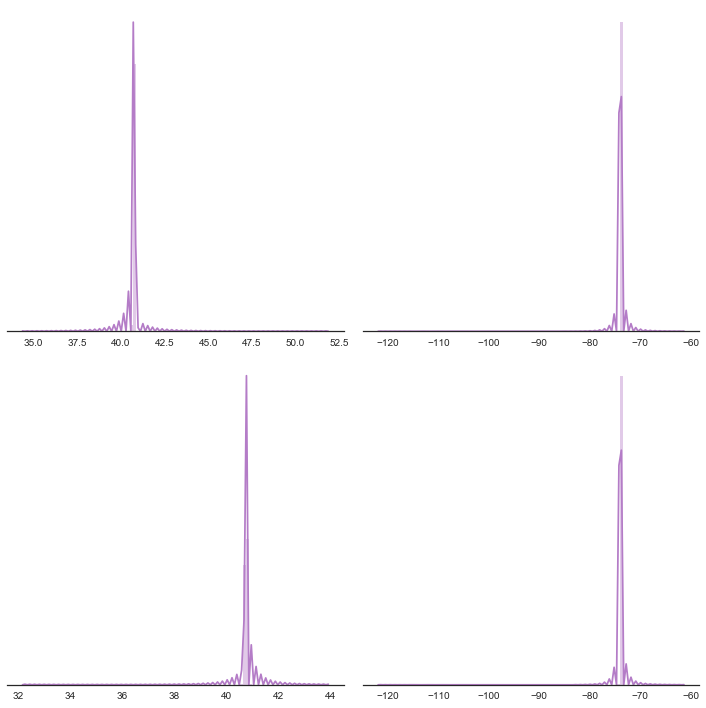

In [8]:
import matplotlib.pyplot as plt
# seaborn sns
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -75.5 to -73.   
Let's remove those large duration trip by using a cap on lat-long and visualize the distributions of latitude and longitude given to us.

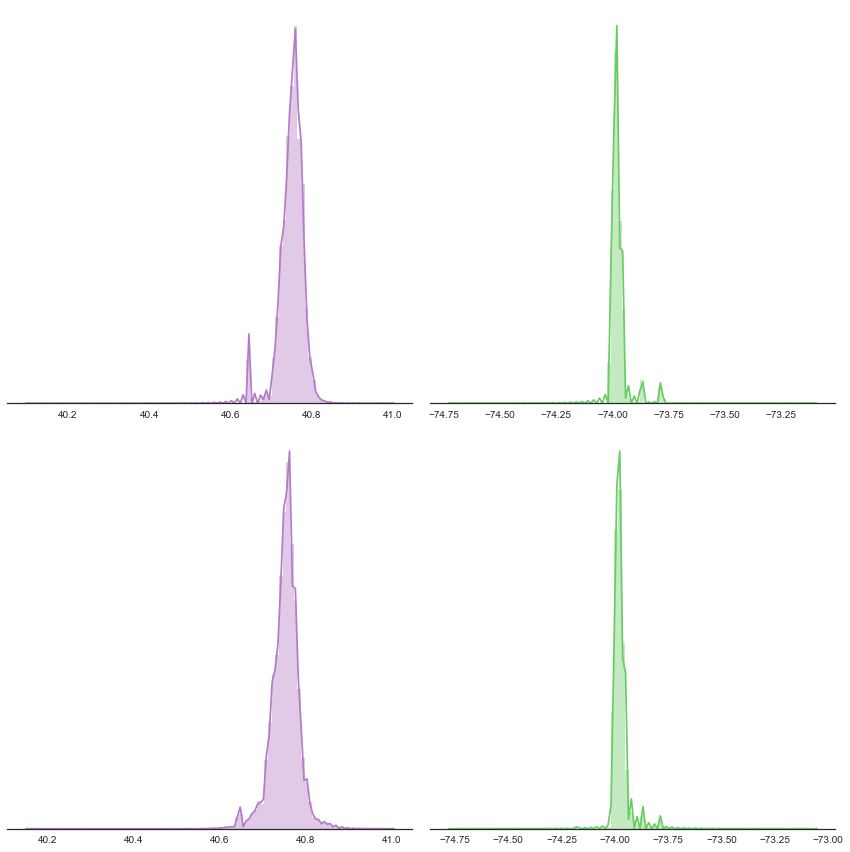

In [9]:
train = train.loc[(train.pickup_latitude > 40) & (train.pickup_latitude < 41)]
train = train.loc[(train.dropoff_latitude>40) & (train.dropoff_latitude < 41)]
train = train.loc[(train.dropoff_longitude > -75.5) & (train.dropoff_longitude < -73)]
train = train.loc[(train.pickup_longitude > -75.5) & (train.pickup_longitude < -73)]
train_data_new = train.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

We put the following caps on lat-long -

**latitude should be between 40.6 to 40.9**  
**Longitude should be between -74.10 to -73.75**  

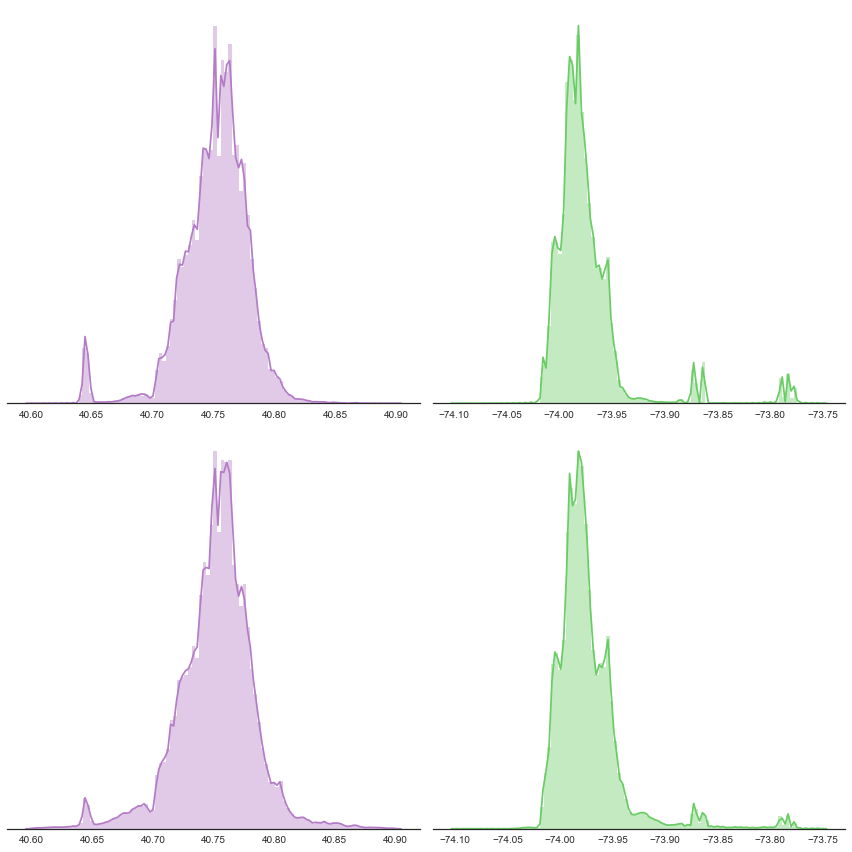

In [10]:
train = train.loc[(train.pickup_latitude > 40.6) & (train.pickup_latitude < 40.9)]
train = train.loc[(train.dropoff_latitude>40.6) & (train.dropoff_latitude < 40.9)]
train = train.loc[(train.dropoff_longitude > -74.10) & (train.dropoff_longitude < -73.75)]
train = train.loc[(train.pickup_longitude > -74.10) & (train.pickup_longitude < -73.75)]
train_data_new = train.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

## Check Missing Values 
check whether we have data missing in the train and the test set.

In [11]:
print(train.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [12]:
print(test.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


**Good! no N/A values**

## Check for duplicate ids

In [13]:
print('No of Duplicates, Trip IDs: {}'.format(len(train) - len(train.drop_duplicates(subset='id'))))

No of Duplicates, Trip IDs: 0


## Check Number of Passengers
The common sense implies values between 1 and 10, we should check 0

In [14]:
print('Passengers: {} to {}'.format(train.passenger_count.min(), train.passenger_count.max()))

Passengers: 0 to 8


## Passenger_Count Clean-up

let's also drop trips with passenger count = 0

In [15]:
print('Empty trips: {}'.format(train[train.passenger_count == 0].shape[0]))
train = train[train.passenger_count > 0]
print('Dropped trips with no passengers')

Empty trips: 57
Dropped trips with no passengers


# Feature Analysis

In [16]:
# Consistency check (check to see whether dropoff_time - pickup_time = duration)

# distributions of pickup_datetime and dropoff_datetime
# Add histogram of trip duration, x-axis is trip duration time (in min), y-axis is counts
# Add histogram of trip duration to show how to remove extre data
# Add histogram of different vendor-id, x-axis:Day (monday, tuesday, etc), y-axis: total count of pick-ups
# Add histogram of different vendor-id, x-axis:hour, y-axis: total count of pick-ups
# Add histogram of Pickup date/time vs trip_duration
# * Trip Distribution for different hours of the day in a week
# * Weekly Trip Distribution for different days of the week
# * Yearly Trip Distribution for different days of the year


In [17]:
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['dropoff_hour'] = pd.DatetimeIndex(train['dropoff_datetime']).hour
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['pickup_hour'] = pd.DatetimeIndex(train['pickup_datetime']).hour
total_rows = len(train.index)

In [18]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dropoff_hour,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,12,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,13


## distributions of Vendors

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


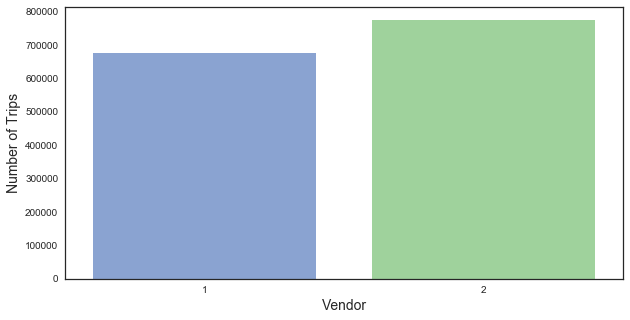

In [19]:
unique_vendors = set(train['vendor_id'].values)
vendor_popularity = train['vendor_id'].value_counts()

f = plt.figure(figsize=(10,5))
sns.barplot(vendor_popularity.index, vendor_popularity.values, alpha=0.7)
plt.xlabel('Vendor', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.show()

## distributions of passenger count

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Maximum number of passengers on a trip :  8
Minimum number of passengers on a trip :  1
Average number of passengers on a trip :  1.66413925223


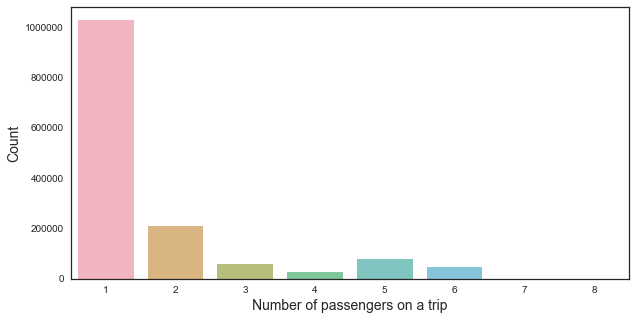

In [20]:
# Moving to passengers count column
pass_count = train['passenger_count']
print("Maximum number of passengers on a trip : ", np.max(pass_count.values))
print("Minimum number of passengers on a trip : ", np.min(pass_count.values))
print("Average number of passengers on a trip : ", np.mean(pass_count.values))

f = plt.figure(figsize=(10,5))
pass_count = train['passenger_count'].value_counts()
sns.barplot(pass_count.index, pass_count.values, alpha=0.7)
plt.xlabel('Number of passengers on a trip', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

## histogram of pickup count by days in a month, x-axis is days in a month, y-axis is pickup counts

In [21]:
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday

train['drop_day'] = train['dropoff_datetime'].dt.day
train['drop_month'] = train['dropoff_datetime'].dt.month
train['drop_weekday'] = train['dropoff_datetime'].dt.weekday

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


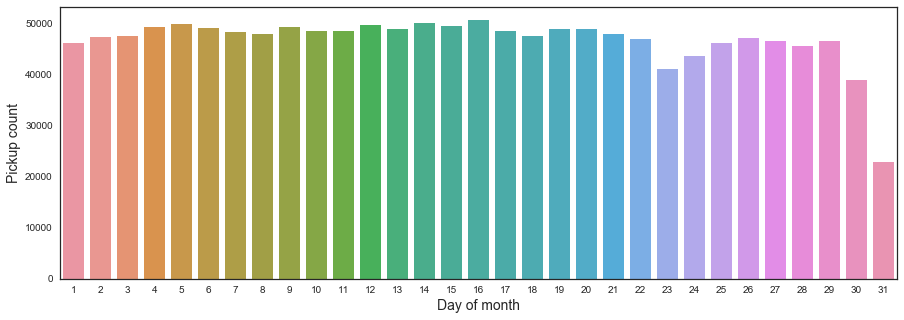

In [22]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_day', data=train)
plt.xlabel('Day of month', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

## histogram of pickup count by months in a year, x-axis is months in a year, y-axis is pickup counts

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


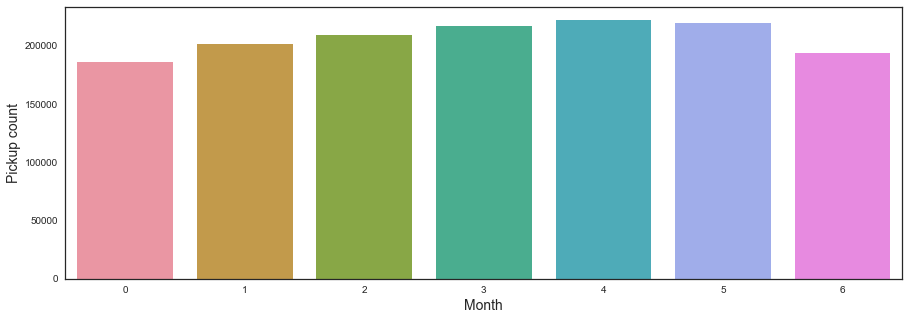

In [23]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_weekday', data=train)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


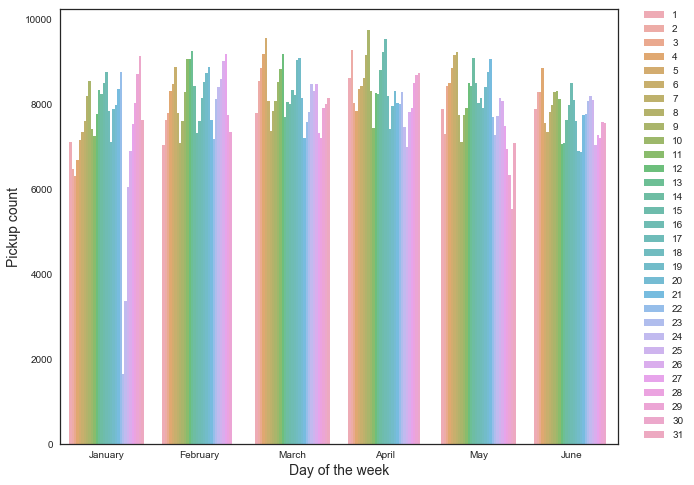

In [24]:
f = plt.figure(figsize=(10,8))
days = [i for i in range(6)]
sns.countplot(x='pickup_month', data=train, hue='pickup_day', alpha=0.8)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.xticks(days, ('January', 'February', 'March', 'April', 'May', 'June'))
plt.legend(loc=(1.04,0))
plt.show()

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
No handles with labels found to put in legend.


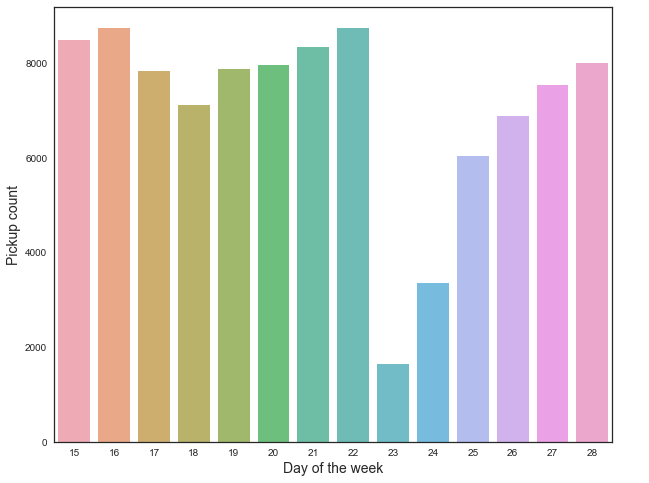

In [25]:
temp = train.copy()
temp['pickup_month'] = temp['pickup_datetime'].dt.month

temp1 = temp.loc[temp['pickup_month'] == 1 & temp['pickup_day'].isin([15,16,17,18,19,20,21,22,23,24,25,26,27,28])]
f = plt.figure(figsize=(10,8))
days = [i for i in range(14)]
sns.countplot(x='pickup_day', data=temp1, alpha=0.8)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.xticks(days, (15,16,17,18,19,20,21,22,23,24,25,26,27,28))
plt.legend(loc=(1.04,0))
plt.show()

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


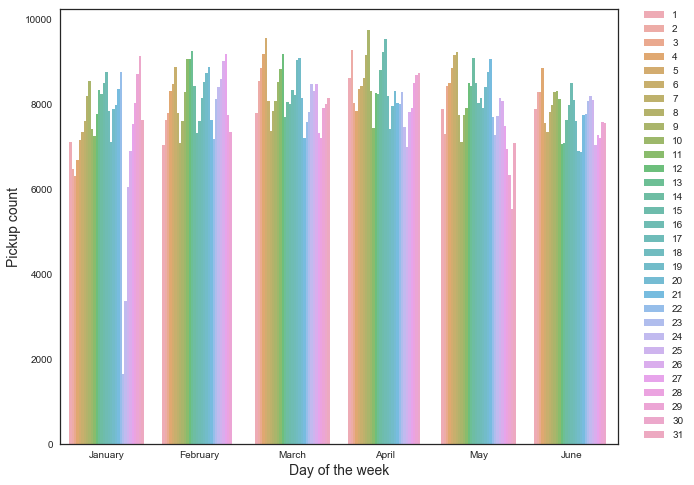

In [26]:
f = plt.figure(figsize=(10,8))
days = [i for i in range(6)]
sns.countplot(x='pickup_month', data=train, hue='pickup_day', alpha=0.8)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.xticks(days, ('January', 'February', 'March', 'April', 'May', 'June'))
plt.legend(loc=(1.04,0))
plt.show()

## histogram of pickup count by days in a week, x-axis is days in a week, y-axis is pickup counts

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


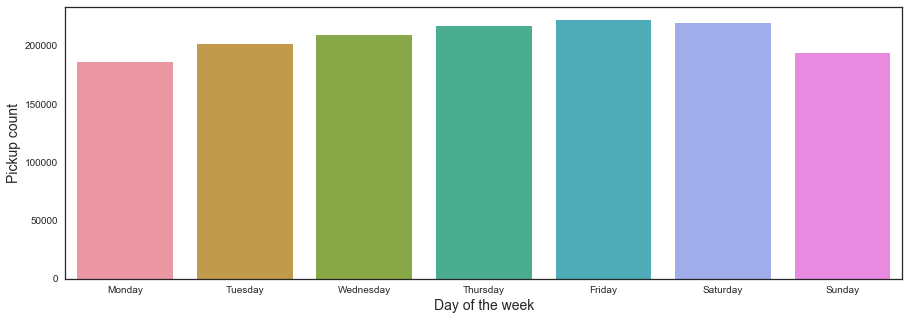

In [27]:
f = plt.figure(figsize=(15,5))
days = [i for i in range(7)]
sns.countplot(x='pickup_weekday', data=train)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.xticks(days, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.show()

## histogram of pickup count by hours in a day, x-axis is hours in a day, y-axis is pickup counts

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


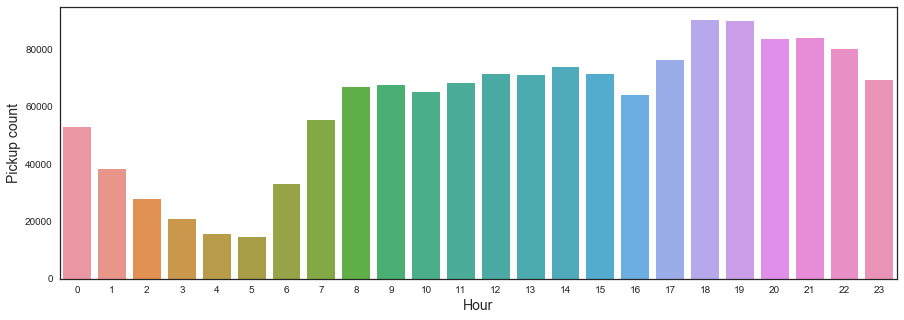

In [28]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_hour', data=train)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

## histogram of pickup count by days in a week and hours in a day, y-axis is pickup counts

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


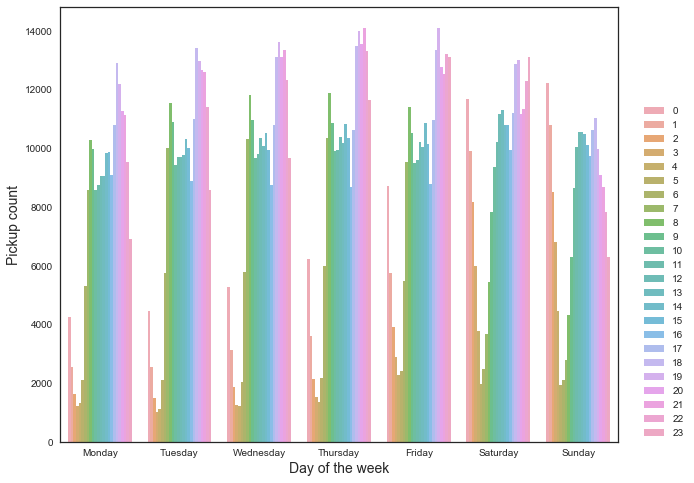

In [29]:
f = plt.figure(figsize=(10,8))
days = [i for i in range(7)]
sns.countplot(x='pickup_weekday', data=train, hue='pickup_hour', alpha=0.8)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.xticks(days, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.legend(loc=(1.04,0))
plt.show()

## Trip Distribution for different hours of the day in a week

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


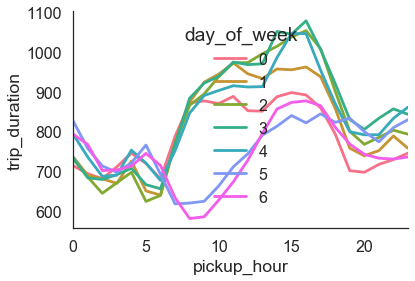

In [30]:
train.loc[:, 'week_of_year'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'day_of_year'] = train['pickup_datetime'].dt.dayofyear
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
summary_hour_duration = pd.DataFrame(train.groupby(['day_of_week','pickup_hour'])['trip_duration'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", condition="day_of_week", value="trip_duration")
sns.despine(bottom = False)


## Yearly Trip Duration Distribution for different days of the year

In [31]:
temp = train.copy()
train.loc[:, 'pick_date'] = train['pickup_datetime'].dt.date

ts_v1 = pd.DataFrame(train.loc[train['vendor_id']==1].groupby('pick_date')['trip_duration'].mean())
ts_v1.reset_index(inplace = True)
ts_v2 = pd.DataFrame(train.loc[train.vendor_id==2].groupby('pick_date')['trip_duration'].mean())
ts_v2.reset_index(inplace = True)

# use BokehJS
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
output_notebook()
p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Yearly Trip Duration Distribution for different days of the year'

for data, name, color in zip([ts_v1, ts_v2], ["vendor 1", "vendor 2"], Spectral4):
    df = data
    p.line(df['pick_date'], df['trip_duration'], line_width=2, color=color, alpha=0.8, legend=name)

p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)
train = temp

Loading BokehJS ...

## Weekly Trip Duration Distribution for different days of the week

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


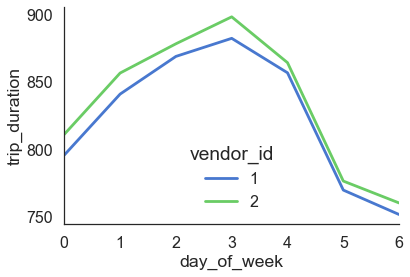

In [32]:
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
summary_wdays_avg_duration = pd.DataFrame(train.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


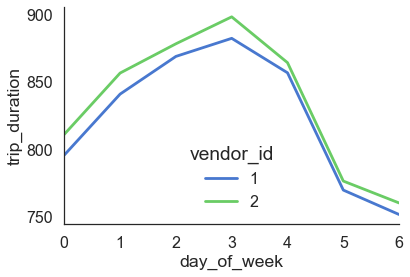

In [33]:
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
summary_wdays_avg_duration = pd.DataFrame(train.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

# Heat Map

In [34]:
heat_df =train.sample(n=10000)

#Extract required columns
heat_df = heat_df[['dropoff_latitude', 'dropoff_longitude','dropoff_hour', 'pickup_latitude', 'pickup_longitude','pickup_hour']]


# Ensure you're handing it floats
heat_df['dropoff_latitude'] = heat_df['dropoff_latitude'].astype(float)
heat_df['dropoff_longitude'] = heat_df['dropoff_longitude'].astype(float)
heat_df['pickup_latitude'] = heat_df['pickup_latitude'].astype(float)
heat_df['pickup_longitude'] = heat_df['pickup_longitude'].astype(float)

#remove NANs
heat_df = heat_df.dropna(axis=0)


# Create weight column, using date
#heat_df['Weight'] = heat_df['dropoff_hour']
heat_df['dropoff_hour'] = heat_df['dropoff_hour'].astype(float)
heat_df['pickup_hour'] = heat_df['pickup_hour'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['dropoff_latitude','dropoff_longitude', 'dropoff_hour','pickup_latitude','pickup_longitude', 'pickup_hour'])

In [35]:
# Display the map based on the pickup location within the time range of (0,24)
# Use Folium to generate heatmap
heat_data_pickup = [[[row['pickup_latitude'],row['pickup_longitude']] 
                for index, row in heat_df[heat_df['pickup_hour'] == i].iterrows()] 
                 for i in range(0,24)]
newyork_on_heatmap_1 = folium.Map(location=[40.767937,-73.982155 ],tiles= "Stamen Terrain",
                    zoom_start = 13)
hm = plugins.HeatMapWithTime(heat_data_pickup,auto_play=True,max_opacity=0.8)
hm.add_to(newyork_on_heatmap_1)

newyork_on_heatmap_1

In [36]:
# Display the map based on the dropoff location within the time range of (0,24)
newyork_on_heatmap = folium.Map(location=[40.767937,-73.982155 ],tiles= "Stamen Terrain",
                    zoom_start = 13) 

# List comprehension to make out list of lists
heat_data = [[[row['dropoff_latitude'],row['dropoff_longitude']] 
                for index, row in heat_df[heat_df['dropoff_hour'] == i].iterrows()] 
                 for i in range(0,24)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(newyork_on_heatmap)

newyork_on_heatmap